In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import sqlite3
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


In [2]:
fName = "/home/bharat/Documents/code/sson_pred/data/filtered-20190103-22-53-substorms.csv"

In [3]:
smssDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smssDF.columns = [ "datetime", "mlat", "mlt" ]
smssDF.head()

,datetime,mlat,mlt
0,1996-01-01 20:16:00,71.32,22.45
1,1996-01-01 23:36:00,70.23,0.07
2,1996-01-02 00:25:00,69.36,22.92
3,1996-01-02 14:12:00,70.06,23.20
4,1996-01-02 16:09:00,65.81,0.62


In [4]:
# Calculate the time diff between two consecutive SS
# onsets in each of the DFs
smlDelTime = smssDF["datetime"].diff()
# convert the difference to minutes
smlDelTime = smlDelTime.apply(\
                lambda x: x.total_seconds()/60. )

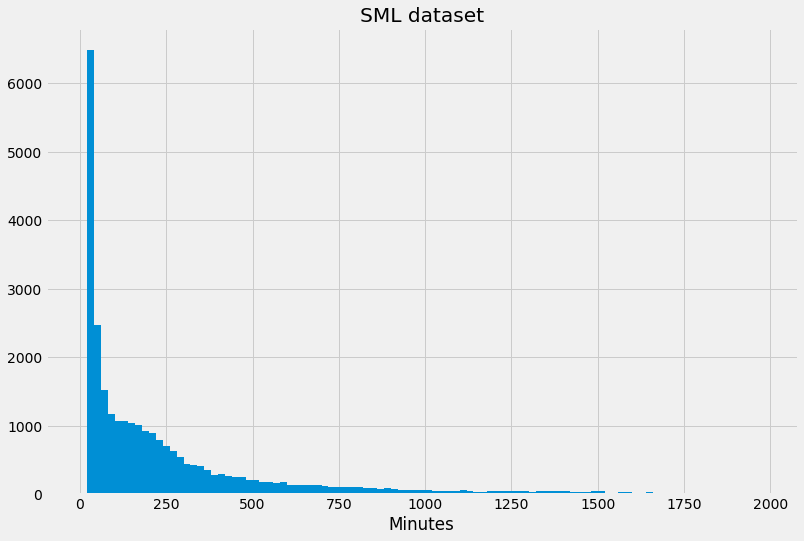

In [5]:
bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(smlDelTime.values[1:], bins=bins)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("Minutes")


f.savefig( "../plots/delT-hist-sml.pdf",bbox_inches='tight' )

In [6]:
# print hist[0]
# print hist[1]

In [7]:
cutOff = 60
blwCutoff = 0
abvCutoff = 0
for _c,_b in zip(hist[0], hist[1]):
    if _b <= cutOff:
        print _b, _c
        blwCutoff += _c
    else:
        abvCutoff += _c
print "cutOff", cutOff
print "blwCutoff", blwCutoff
print "abvCutoff", abvCutoff

0 0.0
20 6487.0
40 2466.0
60 1526.0
cutOff 60
blwCutoff 10479.0
abvCutoff 17580.0


In [8]:
start_date = smssDF["datetime"].min() - datetime.timedelta(hours=2)
end_date = smssDF["datetime"].max()
print start_date, end_date
sml_dbdir = "../data/sqlite3/"
sml_db_name = "smu_sml_sme.sqlite"
sml_table_name = "smusmlsme"

1996-01-01 18:16:00 2017-12-30 21:39:00


In [9]:
# read sml ind data
conn = sqlite3.connect(sml_dbdir + sml_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=sml_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.set_index(smlDF["datetime"], inplace=True)
smlDF.head()

,datetime,al,ae,au
datetime,,,,
1996-01-01 18:16:00,1996-01-01 18:16:00,-22,104,81
1996-01-01 18:17:00,1996-01-01 18:17:00,-22,103,81
1996-01-01 18:18:00,1996-01-01 18:18:00,-21,101,80
1996-01-01 18:19:00,1996-01-01 18:19:00,-23,103,79
1996-01-01 18:20:00,1996-01-01 18:20:00,-21,101,79


In [10]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "omni_sw_imf.sqlite"
omn_table_name = "imf_sw"

In [11]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, Bz, Vx, By FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
omnDF = pandas.read_sql(command, conn)
# drop nan's
omnDF.dropna(inplace=True)
omnDF.set_index(omnDF["datetime"], inplace=True)
omnDF.head()

,datetime,Bz,Vx,By
datetime,,,,
1996-01-01 18:16:00,1996-01-01 18:16:00,-2.61,-407.4,-1.53
1996-01-01 18:17:00,1996-01-01 18:17:00,-2.78,-407.8,-1.79
1996-01-01 18:18:00,1996-01-01 18:18:00,-2.15,-407.9,-2.48
1996-01-01 18:19:00,1996-01-01 18:19:00,-1.81,-411.0,-3.06
1996-01-01 18:20:00,1996-01-01 18:20:00,-1.38,-410.4,-3.03


In [12]:
def get_sml_omn_vars(row):
    """
    Get mean, median, std, min and max of sml 
    during various substorms over the next interval range.
    """
    delTimeList = [30, 60]#[ 15, 30, 60, 120 ]
    for _dtl in delTimeList:
        _pd = row["datetime"] - datetime.timedelta(minutes=10)
        _cd = row["datetime"] + datetime.timedelta(minutes=1)
        _ed = row["datetime"] + datetime.timedelta(minutes=_dtl)
        _resDF = smlDF[ _cd : _ed ]
        _baselineAl = smlDF[ _pd : _cd ]["al"].median()
        _baselineAe = smlDF[ _pd : _cd ]["ae"].median()
        row["mean_al_" + str(_dtl)] = _resDF["al"].mean()
        row["median_al_" + str(_dtl)] = _resDF["al"].median()
        row["min_al_" + str(_dtl)] = _resDF["al"].min()
        row["max_al_" + str(_dtl)] = _resDF["al"].max()
        # difference between current AL and minimum in the next bin
        # note this is defined to be negative, for easy binning etc
        row["al_dip" + str(_dtl)] = _resDF["al"].min() - _baselineAl
        row["ae_dip" + str(_dtl)] = _resDF["ae"].max() - _baselineAe
        
        # similar estimates for omn
        _res_omnDF = omnDF[ _cd : _ed ]
        omnParamList = [ "Bz", "Vx", "By" ]
        for _prm in omnParamList:
            row["mean_" + _prm + "_"+ str(_dtl)] = _res_omnDF[_prm].mean()
            row["median_" + _prm + "_" + str(_dtl)] = _res_omnDF[_prm].median()
            row["min_" + _prm + "_" + str(_dtl)] = _res_omnDF[_prm].min()
            row["max_" + _prm + "_" + str(_dtl)] = _res_omnDF[_prm].max()
        
    return row

smssDF = smssDF.apply( get_sml_omn_vars, axis=1 )
smssDF.head()

,datetime,mlat,mlt,mean_al_30,median_al_30,min_al_30,max_al_30,al_dip30,ae_dip30,mean_Bz_30,...,min_Bz_60,max_Bz_60,mean_Vx_60,median_Vx_60,min_Vx_60,max_Vx_60,mean_By_60,median_By_60,min_By_60,max_By_60
0,1996-01-01 20:16:00,71.32,22.45,-392.800000,-381.0,-604.0,-244.0,-472.0,615.0,2.211304,...,-2.26,3.47,-400.828302,-400.10,-415.3,-391.7,-2.191698,-2.350,-3.11,-0.69
1,1996-01-01 23:36:00,70.23,0.07,-194.033333,-186.5,-317.0,-109.0,-269.5,266.0,-1.267000,...,-3.14,2.60,-396.425424,-396.90,-404.9,-389.9,-2.820169,-2.840,-3.40,-1.98
2,1996-01-02 00:25:00,69.36,22.92,-231.466667,-229.0,-348.0,-133.0,-276.0,270.5,0.076552,...,-1.39,0.80,-392.691379,-391.75,-400.7,-384.6,-3.546897,-3.575,-4.39,-2.84
3,1996-01-02 14:12:00,70.06,23.20,-151.733333,-144.5,-222.0,-80.0,-186.0,226.5,-2.207619,...,-4.28,-0.24,-374.922222,-375.00,-378.0,-369.4,0.329111,0.950,-2.59,1.58
4,1996-01-02 16:09:00,65.81,0.62,-294.733333,-287.0,-476.0,-169.0,-357.0,412.0,-0.224667,...,-3.37,2.05,-379.891525,-382.90,-388.3,-361.3,-2.478136,-2.500,-4.70,1.12


In [66]:
bigSS = smssDF[ smssDF["al_dip60"] <= -600 ].reset_index(drop=True)
smallSS = smssDF[ smssDF["al_dip60"] >= -200 ].reset_index(drop=True)
medSS = smssDF[ (smssDF["al_dip60"] <= -400) &\
              (smssDF["al_dip60"] >= -600) ].reset_index(drop=True)

In [59]:
bigSS[[ "min_Bz_30", "mean_By_30", "min_Vx_30" ]].describe()

,min_Bz_30,mean_By_30,min_Vx_30
count,3538.000000,3538.000000,3538.000000
mean,-7.338369,1.393044,-569.621792
std,5.078314,5.483677,125.770013
min,-50.180000,-27.007667,-1056.000000
25%,-9.290000,-1.533571,-658.475000
50%,-6.220000,1.261190,-566.400000
75%,-4.230000,3.867672,-467.775000
max,14.850000,39.430345,-305.600000


In [60]:
smallSS[[ "min_Bz_30", "mean_By_30", "min_Vx_30" ]].describe()

,min_Bz_30,mean_By_30,min_Vx_30
count,4514.000000,4514.000000,4514.000000
mean,-3.541983,0.531761,-493.781657
std,3.247279,4.413745,115.078522
min,-36.390000,-19.359375,-992.900000
25%,-5.010000,-2.425227,-576.675000
50%,-3.250000,0.559959,-474.600000
75%,-1.650000,3.161176,-401.150000
max,32.470000,36.571667,-268.600000


In [163]:
smssDF[[ "min_Bz_30", "mean_By_30", "min_Vx_30" ]].describe()

,min_Bz_30,mean_By_30,min_Vx_30
count,28263.000000,28263.000000,28263.000000
mean,-4.656342,0.712315,-519.554955
std,3.817534,4.591649,120.030443
min,-50.180000,-27.884138,-1056.000000
25%,-6.190000,-2.129250,-607.900000
50%,-4.120000,0.731111,-505.200000
75%,-2.420000,3.259188,-423.750000
max,32.470000,39.876071,-257.300000


(-20, 20)

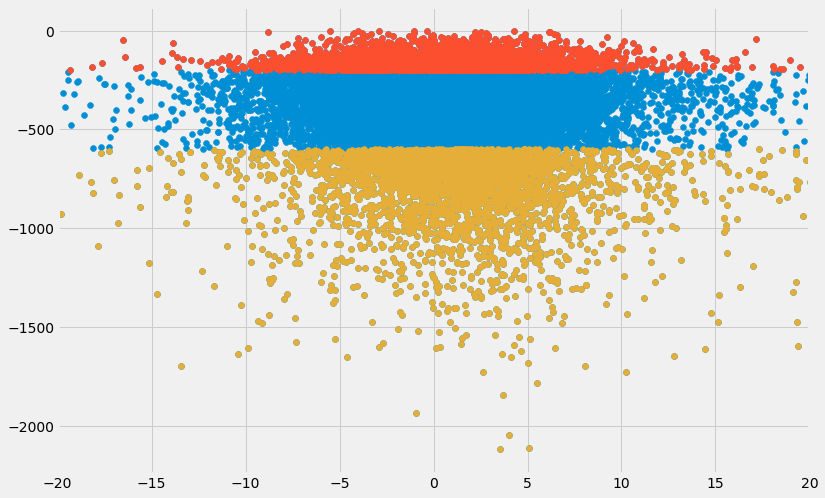

In [40]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.scatter( smssDF["mean_By_30"].values, smssDF["al_dip60"].values )
ax.scatter( smallSS["mean_By_30"].values, smallSS["al_dip60"].values )

ax.scatter( bigSS["mean_By_30"].values, bigSS["al_dip60"].values )

ax.set_xlim([-20,20])

# smallSS.plot(x="al_dip60", y="mean_Bz_30", kind="scatter")

(-20, 20)

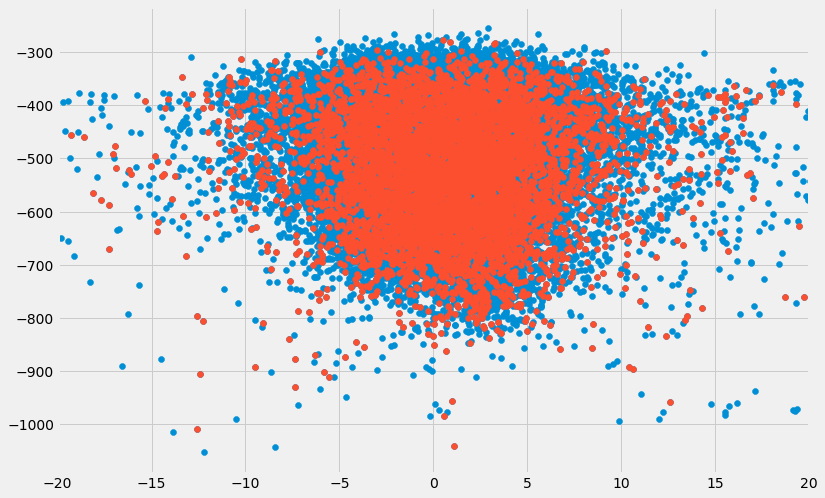

In [86]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.scatter( smssDF["mean_By_30"].values, smssDF["mean_Vx_30"].values )
# ax.scatter( smallSS["mean_By_30"].values, smallSS["mean_Vx_30"].values )

# ax.scatter( bigSS["mean_By_30"].values, bigSS["mean_Vx_30"].values )
ax.scatter( medSS["mean_By_30"].values, medSS["mean_Vx_30"].values )

ax.set_xlim([-20,20])

# smallSS.plot(x="al_dip60", y="mean_Bz_30", kind="scatter")

In [152]:
byCutoff = 7.5
byNegDF = smssDF[ smssDF["mean_By_30"] <= -1*byCutoff ]
byPosDF = smssDF[ smssDF["mean_By_30"] >= byCutoff ]

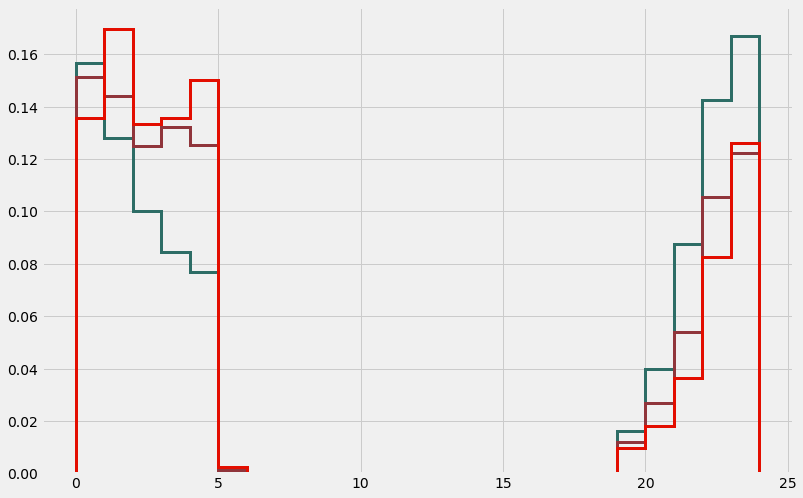

In [162]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

bins = range(25)

# histogram of the entire data
n, bins, patches = ax.hist( smssDF["mlt"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#2d6d66", label="All", normed=True )

# histogram of the pos By dominated
n, bins, patches = ax.hist( byPosDF["mlt"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#90353b", label="Pos By", normed=True )

# # # histogram of the neg By dominated
n, bins, patches = ax.hist( byNegDF["mlt"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#e30e00", label="Neg By", normed=True )

(-20, 20)

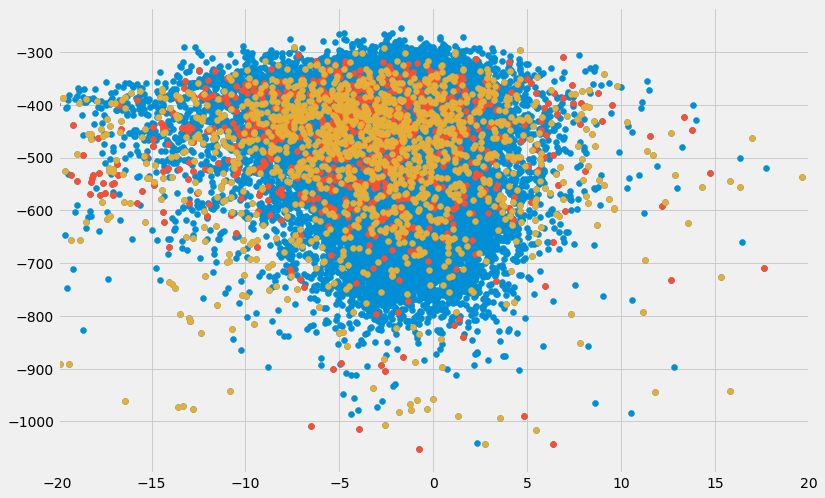

In [160]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.scatter( smssDF["mean_Bz_30"].values, smssDF["mean_Vx_30"].values )
ax.scatter( byNegDF["mean_Bz_30"].values, byNegDF["mean_Vx_30"].values )

# ax.scatter( bigSS["mean_By_30"].values, bigSS["mean_Vx_30"].values )
ax.scatter( byPosDF["mean_Bz_30"].values, byPosDF["mean_Vx_30"].values )

ax.set_xlim([-20,20])

# smallSS.plot(x="al_dip60", y="mean_Bz_30", kind="scatter")

In [154]:
byNegDF[["al_dip60", "mean_Bz_30", "mean_Vx_30", "mlat", "mlt"]].describe()

,al_dip60,mean_Bz_30,mean_Vx_30,mlat,mlt
count,825.000000,825.000000,825.000000,825.000000,825.000000
mean,-412.970303,-4.022784,-478.568559,66.137576,7.994982
std,248.791117,6.046824,109.316118,3.077731,9.060968
min,-1700.000000,-38.287241,-1052.400000,56.350000,0.010000
25%,-511.000000,-7.084483,-537.648148,64.800000,1.640000
50%,-344.000000,-3.417857,-455.477778,65.960000,3.540000
75%,-247.000000,-0.376552,-398.083333,67.560000,20.780000
max,-5.000000,33.920667,-305.100000,74.520000,23.960000


In [155]:
byPosDF[["al_dip60", "mean_Bz_30", "mean_Vx_30", "mlat", "mlt"]].describe()

,al_dip60,mean_Bz_30,mean_Vx_30,mlat,mlt
count,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000
mean,-434.853471,-3.749871,-498.068043,65.471816,8.827423
std,258.991122,6.479899,122.537470,2.915502,9.479697
min,-1730.500000,-31.673448,-1042.616667,55.590000,0.000000
25%,-559.500000,-7.163294,-558.461944,64.262500,1.702500
50%,-365.500000,-3.320000,-468.881527,65.450000,3.590000
75%,-248.500000,0.060060,-411.682813,66.710000,21.680000
max,-30.500000,30.263704,-290.444444,74.170000,23.990000


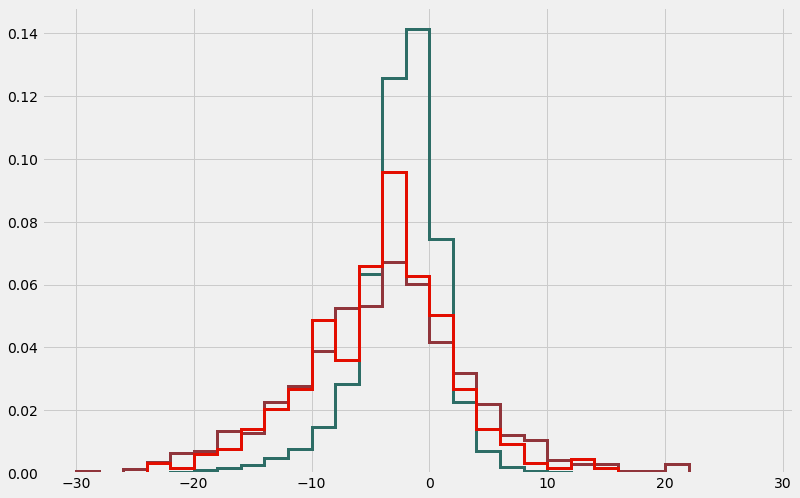

In [136]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

bins = range(-30,30,2)#range(25)

# histogram of the entire data
n, bins, patches = ax.hist( smssDF["mean_Bz_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#2d6d66", label="All", normed=True )

# histogram of the pos By dominated
n, bins, patches = ax.hist( byPosDF["mean_Bz_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#90353b", label="Pos By", normed=True )

# # # histogram of the neg By dominated
n, bins, patches = ax.hist( byNegDF["mean_Bz_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#e30e00", label="Neg By", normed=True )

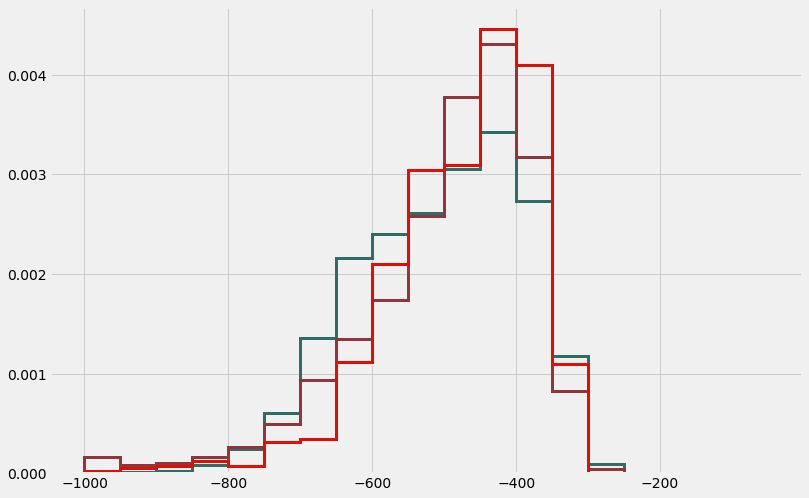

In [161]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

bins = range(-1000,0,50)#range(25)

# histogram of the entire data
n, bins, patches = ax.hist( smssDF["mean_Vx_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#2d6d66", label="All", normed=True )

# histogram of the pos By dominated
n, bins, patches = ax.hist( byPosDF["mean_Vx_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#90353b", label="Pos By", normed=True )

# # # histogram of the neg By dominated
n, bins, patches = ax.hist( byNegDF["mean_Vx_30"].values,\
                           bins=bins, histtype='step',linewidth=3,\
                           color="#e30e00", label="Neg By", normed=True )